# Линейная регрессия
__Суммарное количество баллов: 10__


In [192]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

In [303]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.loc[:, df.columns != 'label']
    X = (X - X.mean(axis=0))/X.std(axis=0)
    y = df.label.astype('category')
    y = df.label.apply(lambda x: 1 if x=='M' else 0)
    return (X,y)

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    #df.capital_run_length_average = (df.capital_run_length_average-df.capital_run_length_average.mean())/df.capital_run_length_average.std()
    #df.capital_run_length_longest = (df.capital_run_length_longest-df.capital_run_length_longest.mean())/df.capital_run_length_longest.std()
    #df.capital_run_length_total = (df.capital_run_length_total-df.capital_run_length_total.mean())/df.capital_run_length_total.std()
    X = df.loc[:, df.columns != 'label']
    X = (X - X.mean(axis=0))/X.std(axis=0)
    y = df.label.astype('float')
    return (X,y)

In [4]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [5]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [79]:
class NormalLR:
    def __init__(self):

        pass
    
    def _appendOnes(self, X):
        return np.append(X, [[1]]*X.shape[0], axis=1)

    def fit(self, X, y):
        _X = self._appendOnes(X)
        self.w = np.linalg.inv(_X.T.dot(_X)).dot(_X.T).dot(y)
    
    def predict(self, X):
        _X = self._appendOnes(X)
        return _X.dot(self.w)

In [80]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [81]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.010681862583791418


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с learning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [473]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, l=0.01):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l

    def _appendOnes(self, X):
        return np.append(X, [[1]]*X.shape[0], axis=1)
    
    def fit(self, X, y):
        _X = self._appendOnes(X)
        self.w = np.zeros(X.shape[1] + 1)
        n = len(X)
        for i in range(0, self.iterations):
            grad = 2/n*_X.T.dot(_X.dot(self.w) - y) + self.l*np.sign(self.w)
            self.w = self.w - grad*self.alpha

    def predict(self, X):
        _X = self._appendOnes(X)
        return _X.dot(self.w)       

In [445]:
def build_plot(X_train, y_train, X_test, y_test, alpha, lList):
    #plt.plot
    np.random.seed(128)
    regr = GradientLR(alpha, iterations=10000)
    errList = []
    for l in lList:
        regr.l = l
        regr.fit(X_train, y_train)
        errList.append(mse(y_test, regr.predict(X_test)))
    plt.plot(lList,errList)
    plt.xlabel("Reg. coeff, l")
    plt.ylabel("MSE")

In [446]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

0.01060208893545924


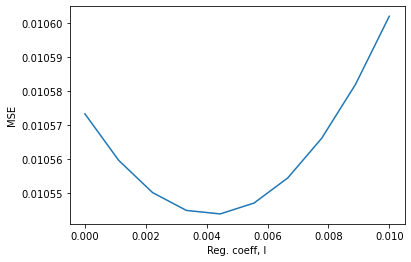

In [447]:
regr = GradientLR(0.10, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
lList = np.linspace(0,0.01,10)
build_plot(X_train, y_train, X_test, y_test, 0.01, lList)

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [479]:
def plotAll(data = "boston"):
    if(data == "boston"):
        X, y = read_data()
        X_sh = X - X.mean(axis=0)
        X = X_sh/X_sh.std(axis=0)
        y = y/y.max()
        lList = np.linspace(0,0.5,50)
        alpha = 0.01
    elif(data=="cancer"):
        X, y = read_cancer_dataset("cancer.csv")
        lList = np.linspace(0,0.05,50)
        alpha = 0.002
    elif(data=="spam"):
        X, y = read_spam_dataset("spam.csv")
        lList = np.linspace(0,0.02,50)
        alpha = 0.05

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

    regr = NormalLR()
    regr.fit(X_train, y_train)
    print("NormalR, MSE: ", mse(y_test, regr.predict(X_test)))

    regr = GradientLR(alpha, iterations=10000)
    regr.fit(X_train, y_train)
    print("GradientR, MSE:", mse(y_test, regr.predict(X_test)))
    
    build_plot(X_train, y_train, X_test, y_test, alpha, lList)

NormalR, MSE:  0.013119945072082233
GradientR, MSE: 0.009779887046276123


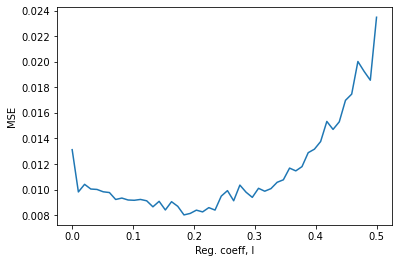

In [474]:
plotAll("boston")

NormalR, MSE:  0.05399513410124763
GradientR, MSE: 0.04897135237548557


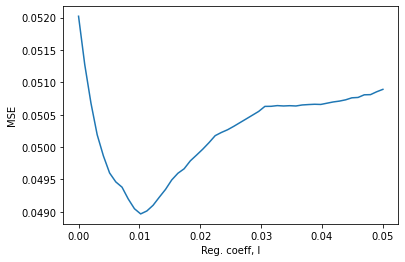

In [475]:
plotAll("cancer")

NormalR, MSE:  0.10854423019754153
GradientR, MSE: 0.10948870842192208


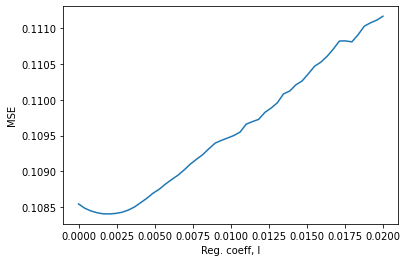

In [480]:
plotAll("spam")